# Functional Data Analysis of oceanographic profiles for python (fda_oce_python)

**Functional Data Analysis** is a set of tools to study curves or functions. Here we see vertical profiles of temperature (T) and salinity (S) as curves and apply a functional principal component analysis (FPCA) in the multivaraite case (T and S) to reduce the dimensionality of the system. It can be used for front detection, water mass identification, unsupervised or supervised classification, model comparison, data calibration ...

*References*: 
- Pauthenet et al. (2019) The thermohaline modes of the global ocean. Journal of Physical Oceanography, [10.1175/JPO-D-19-0120.1](https://doi.org/10.1175/JPO-D-19-0120.1)
- Pauthenet et al. (2018) Seasonal meandering of the Polar Front upstream of the Kerguelen Plateau. Geophysical Research Letters, [10.1029/2018GL079614](https://doi.org/10.1029/2018GL079614)
- Pauthenet et al. (2017) A linear decomposition of the Southern Ocean thermohaline structure. Journal of Physical Oceanography, [10.1175/JPO-D-16-0083.1](http://dx.doi.org/10.1175/JPO-D-16-0083.1)
- Ramsay, J. O., and B. W. Silverman, 2005: Functional Data Analysis. 2nd Edition Springer, 426 pp., Isbn : 038740080X.

*Author*:
- Fabien Roquet (fabien.roquet@gu.se)
- Etienne Pauthenet (etienne.pauthenet@locean-ipsl.upmc.fr)


# Installation of fda.oce:

You must first install R on your system.

**using Anaconda** If you have installed Anaconda, you can install it in a new environment *fda_env* by executing in your terminal the commands:
``` r
conda create -n fda_env --yes
conda activate fda_env
conda install python=3.6 --yes
conda install -c conda-forge r r-devtools rpy2 r-fda --yes
conda install -c conda-forge jupyterlab --yes
conda install -c conda-forge numpy --yes
conda install -c conda-forge scipy --yes
conda install -c conda-forge matplotlib --yes
```
Note that we use python 3.6 because at this date, the R module fda is not compatible with later versions of python.

Before opening jupyter lab (or jupyter notebook), make sure you select the right conda environment. This can be done from the Anaconda graphical interface, or using the command line:
``` r
conda activate fda_env
```

Download the github folder fda_oce_python, move there in your terminal and open jupyter lab:
``` r
conda activate fda_env
jupyter lab
```

You should now be able to execute the code in the fda_oce_python.ipynb file. Note that you may have to modify the variable *os.environ['R_HOME']* defined below in order to access R from python.


**otherwise** If you have an installation of R obtained differently, you may install devtools by executing in R the command:
``` r
install.packages("devtools")
install.packages("fda")
```
You should then find the path to the executable R, and set the variable *os.environ['R_HOME']* just below in order to access R from python.


In [1]:
# Set the R_HOME environment variable to the R home directory
# To know the path of your R_HOME, execute in R the command R.home()
import os
os.environ['R_HOME'] = '/opt/tljh/user/lib/R'
os.environ['R_USER'] = '/opt/tljh/user/lib/python3.7/site-packages/rpy2'

# Test if rpy2 is installed and print version
import rpy2
print("rpy2 version "+str(rpy2.__version__))

# change your working directory
path = "./"
os.chdir(path)

# load fda_oce_python functions
import fda_oce_python as fda_oce

rpy2 version 3.3.2


# Demo
Here is an example of how to use these functions. We compute the modes for a subsample (given here in a .mat format) of the reanalysis [GLORYS](http://marine.copernicus.eu/services-portfolio/access-to-products/) in the Southern Ocean for December of 2015.

First we load the data and fit the Bsplines on the 1691 profiles of the example, between 5 and 1000m with 20 Bsplines :
``` r
import scipy.io
data = scipy.io.loadmat('GLORYS_SO_2015-12.mat')
Pi=data['Pi']
Xi=data['Xi']
```

In [2]:
import scipy.io
data = scipy.io.loadmat('GLORYS_SO_2015-12.mat')
Pi=data['Pi']
Xi=data['Xi']

Then we first computing the B-spline coefficients:
``` r
fdobj = bspl(Pi,Xi)
```

An example of reconstruction is given to show how splines approximate the true TS profiles. Note that a larger number of splines (parameter nbas) gives a better approximation at the expense of computing load.

In [3]:
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import numpy2ri

with localconverter(numpy2ri.converter) as cv:
    Xi_R = cv.py2rpy(Xi)



1691 B-splines computed for 2 variables.


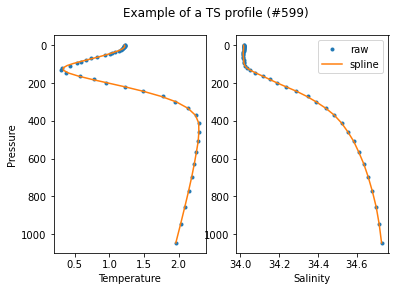

In [3]:
fdobj = fda_oce.bspl(Pi,Xi)
X_spli = fda_oce.data_from_fdobj(Pi,fdobj)

ii   = 599  #index of a profile
ndim = X_spli.shape[2]

import matplotlib.pyplot as plt
fig = plt.figure()
for kk in range(ndim): #Loop for each variable                        
    plt.subplot(1,ndim,kk+1)
    plt.plot(Xi[:,ii,kk],Pi,'.',X_spli[:,ii,kk],Pi)
    plt.ylim(plt.ylim()[::-1])
    plt.xlabel(fdobj[2][kk+2])
    if kk==0:
        plt.ylabel("Pressure")
    if kk==ndim-1:
        plt.legend(('raw','spline'))
    plt.suptitle("Example of a TS profile (#599)")


We can now apply the fPCA on our dataset, by applying a standard PCA directly on the B-spline coefficients.

In [5]:
pca = fda_oce.fpca(fdobj)

The profiles can be projected on the modes defined by the FPCA, to get the principal components (PCs), using the function *pc_from_fdobj*. A visualisation of the 2 first PCs is presented here.

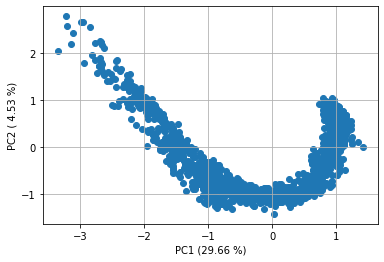

In [6]:
pc = fda_oce.pc_from_fdobj(fdobj,pca)
fda_oce.pc_plot(pca, pc, sign=[-1,1])

Visualisation of the effect of the first mode PC1 on the mean profile (red (+1) and blue (-1)) :

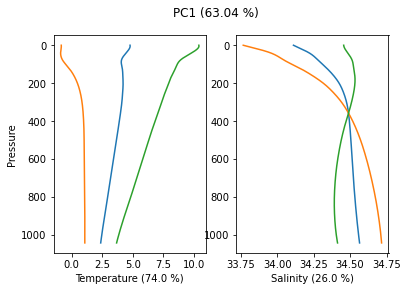

In [7]:
fda_oce.eigenf_plot(pca, npc=1, sign=-1)

The profiles can then be reconstructed with less PCs than the total number, removing the small variability. For example with only 5 modes :

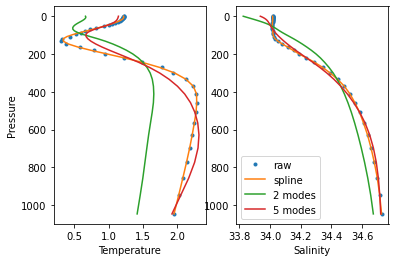

In [8]:
fdobj_reco = fda_oce.fdobj_from_pc(pca,pc,2) # reconstruction with 2 modes
X_reco_1 = fda_oce.data_from_fdobj(Pi,fdobj_reco)

fdobj_reco = fda_oce.fdobj_from_pc(pca,pc,5) # reconstruction with 5 modes
X_reco_2 = fda_oce.data_from_fdobj(Pi,fdobj_reco)

ii   = 599  #index of a profile
ndim = pca['ndim']

fig = plt.figure()
for kk in range(ndim): #Loop for each variable                        
    plt.subplot(1,ndim,kk+1)
    plt.plot(Xi[:,ii,kk],Pi,'.',X_spli[:,ii,kk],Pi,X_reco_1[:,ii,kk],Pi,X_reco_2[:,ii,kk],Pi)
    plt.ylim(plt.ylim()[::-1])
    plt.xlabel(pca['fdnames'][kk+2])
    if kk==0:
        plt.ylabel("Pressure")
    if kk==ndim-1:
        plt.legend(('raw','spline','2 modes','5 modes'))
